In [1]:
import os
import sys
import json
from time import perf_counter

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorboard as tb
import pandas as pd
from tqdm import tqdm

In [2]:
sys.path.append(os.path.join(os.getcwd(), "../src"))

from models import models
from core.dataset import output_dataset
from core.metrics import TopKThroughputRatio
from core.pruning import prune_model, get_gzipped_model_size, get_gzipped_model_weights_size

## Top K accuracy and throughput ratio

In [3]:
eval_filenames = [filename for filename in os.listdir('eval/')]
max_k = 20

In [4]:
def top_k_eval(filenames, names):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    for filename, name in zip(filenames, names):
        with open(f'eval/{filename}') as file:
            results = json.load(file)

        axs[0].plot(np.arange(max_k), results['top-k-accuracy'][:max_k], label=name)
        axs[1].plot(np.arange(max_k), results['top-k-throughput-ratio'][:max_k], label=name)

    axs[1].legend(title='Models', bbox_to_anchor=(1.05, 1))
    axs[0].set_title('Top K Accuracy')
    axs[1].set_title('Top K Throughput Ratio')
    axs[0].set_xlim(0, 20)
    axs[1].set_xlim(0, 20)
    
    plt.tight_layout()
    return fig, axs

### All

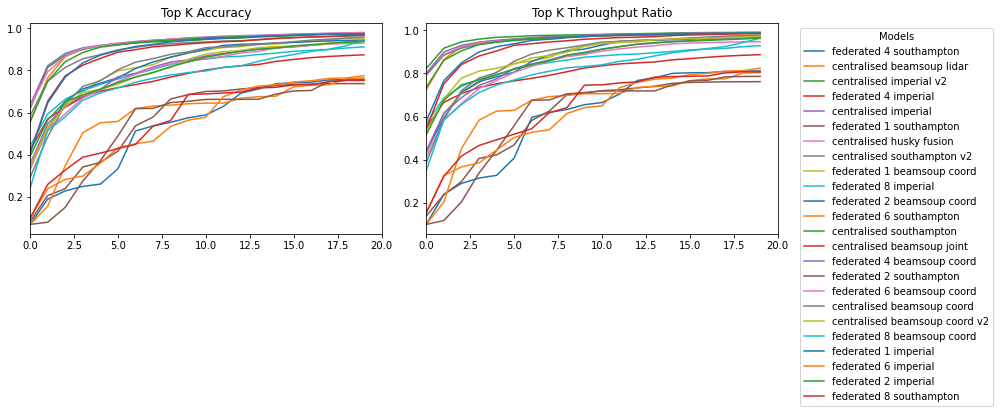

In [5]:
top_k_eval(eval_filenames, [f.replace('.json', '').replace('-', ' ') for f in eval_filenames])
plt.savefig('figs/top-k.png')

### Centralised

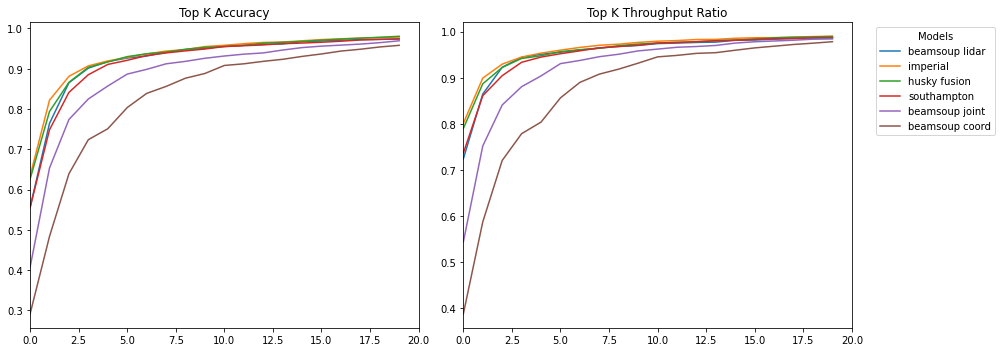

In [6]:
centralised_eval_filenames = [filename for filename in eval_filenames 
                              if 'centralised' in filename and 'v2' not in filename]
top_k_eval(centralised_eval_filenames, [f.replace('.json', '').replace('-', ' ').replace('centralised ', '') 
                                        for f in centralised_eval_filenames])
plt.savefig('figs/centralised-top-k.png')

### Lidar, Coord, Lidar+Coord models

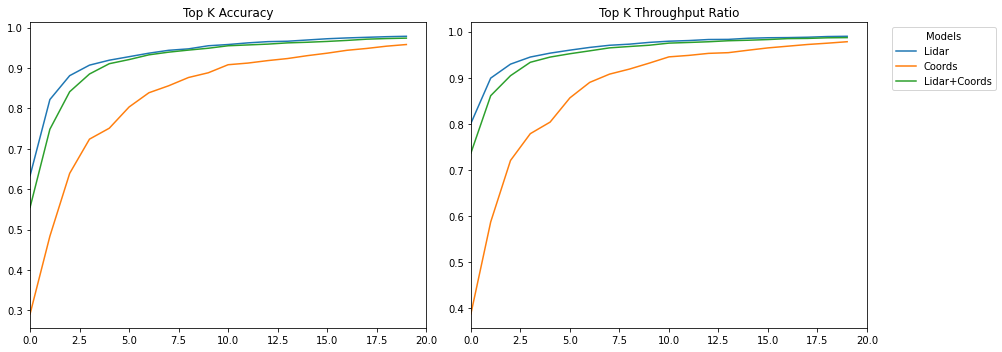

In [8]:
limited_eval_filenames = [f'centralised-{model_name}.json' for model_name in ['imperial', 'beamsoup-coord', 'southampton']]
top_k_eval(limited_eval_filenames, ['Lidar', 'Coords', 'Lidar+Coords'])
plt.savefig('figs/centralised-3-top-k.png')

### Federated

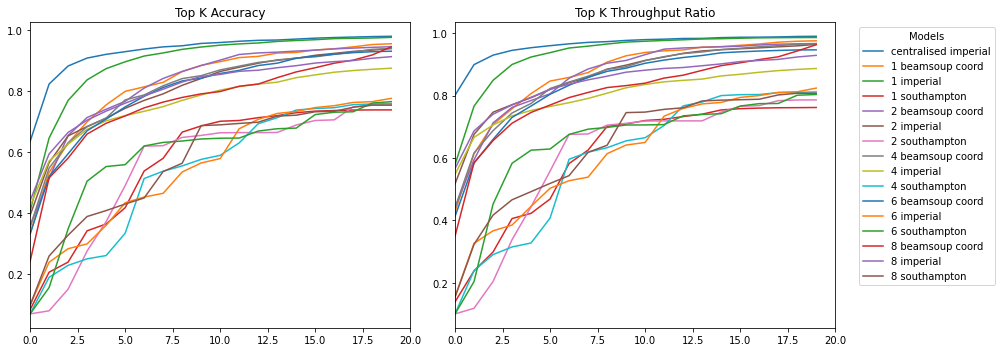

In [9]:
federated_eval_filenames = sorted([filename for filename in eval_filenames 
                                   if 'federated' in filename or filename == 'centralised-imperial.json'])
top_k_eval(federated_eval_filenames, [f.replace('.json', '').replace('-', ' ').replace('federated ', '') 
                                      for f in federated_eval_filenames])
plt.savefig('figs/federated-top-k.png')

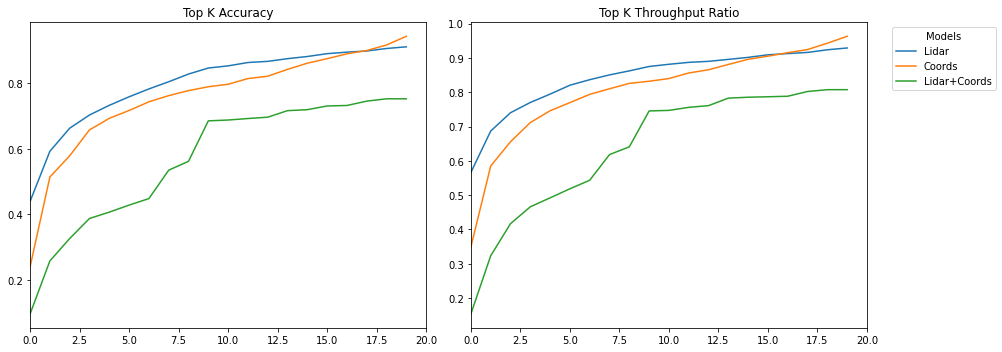

In [11]:
limited_eval_filenames = [f'federated-8-{model_name}.json' for model_name in ['imperial', 'beamsoup-coord', 'southampton']]
top_k_eval(limited_eval_filenames, ['Lidar', 'Coords', 'Lidar+Coords'])
plt.savefig('figs/federated-3-top-k.png')

## True output

62/62 [==============================] - 2s 19ms/step - loss: 1.6776 - top-1-accuracy: 0.6337 - top-10-accuracy: 0.9551 - top-1-throughput: 0.7841 - top-10-throughput: 0.9742


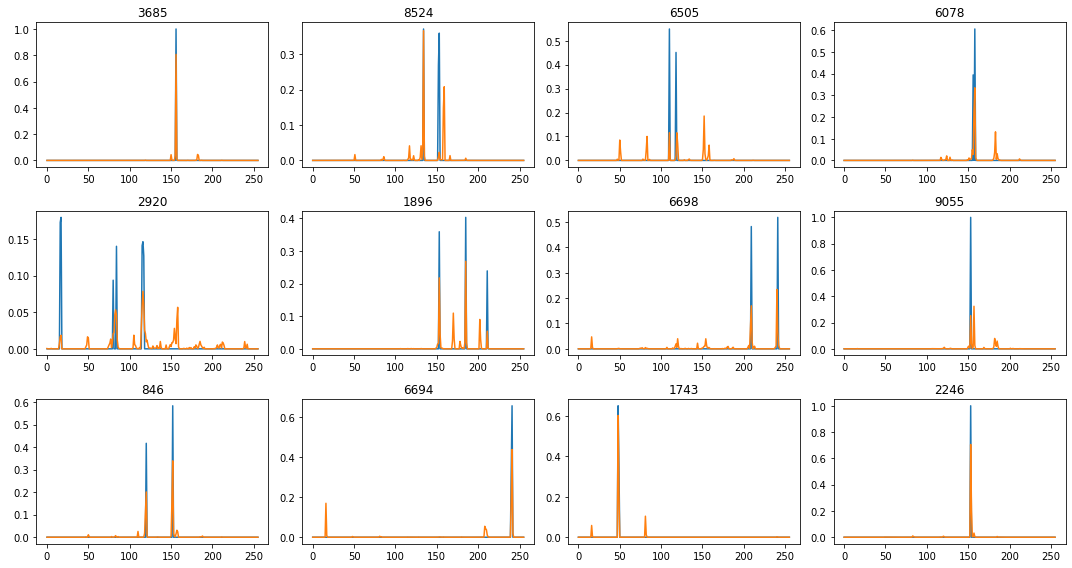

In [10]:
model_fn, dataset_fn = models['imperial']
model = tf.keras.models.load_model('models/centralised-imperial/model', 
                                   custom_objects={'TopKThroughputRatio': TopKThroughputRatio})

training_input, validation_input = dataset_fn()
training_output, validation_output = output_dataset()

fig, axs = plt.subplots(3, 4, figsize=(15, 8))
for ax in axs.flatten():
    pos = np.random.randint(0, len(training_input))
    ax.plot(np.arange(256), training_output[pos], label='True')
    ax.plot(np.arange(256), model(np.array([training_input[pos]]))[0], label='Predicted')
    ax.set_title(pos)
    
plt.tight_layout()
plt.savefig('figs/true-output.png')

evaluation = model.evaluate(validation_input, validation_output)

### True output v2

62/62 [==============================] - 2s 20ms/step - loss: 4.5066 - top-1-accuracy: 0.6173 - top-10-accuracy: 0.9418 - top-1-throughput: 0.8048 - top-10-throughput: 0.9742


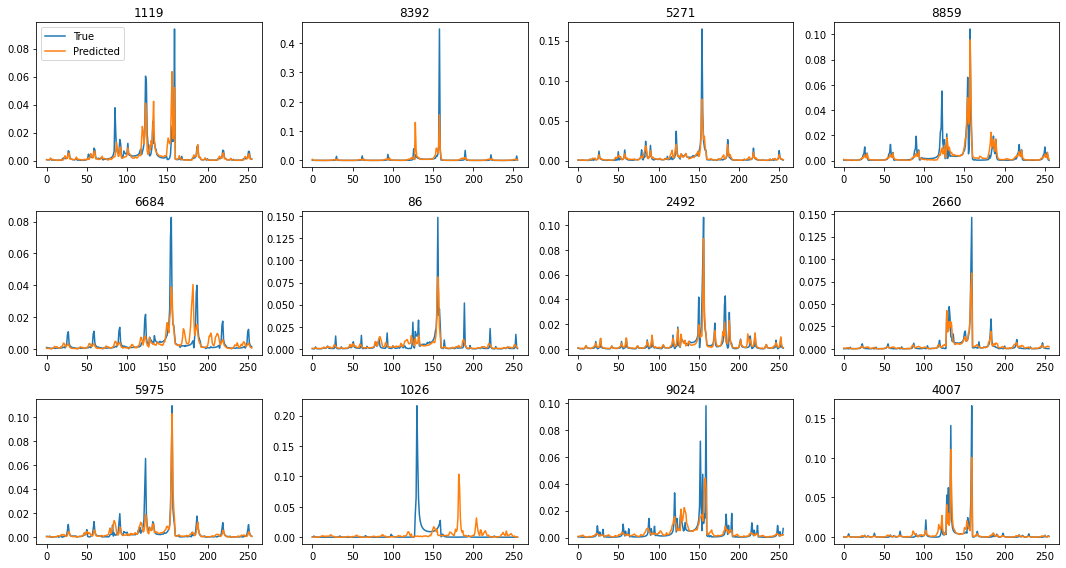

In [12]:
model_fn, dataset_fn = models['imperial']
model = tf.keras.models.load_model('models/centralised-imperial-v2/model', 
                                   custom_objects={'TopKThroughputRatio': TopKThroughputRatio})

training_input, validation_input = dataset_fn()
training_output, validation_output = output_dataset(version='v2')

fig, axs = plt.subplots(3, 4, figsize=(15, 8))
for ax in axs.flatten():
    pos = np.random.randint(0, len(training_input))
    ax.set_title(pos)
    ax.plot(np.arange(256), training_output[pos], label='True')
    ax.plot(np.arange(256), model(np.array([training_input[pos]]))[0], label='Predicted')

axs[0, 0].legend()
plt.tight_layout()
plt.savefig('figs/true-output-v2.png')
evaluation = model.evaluate(validation_input, validation_output)

## Training tensorboard

In [13]:
metrics = ['loss', 'top-1-accuracy', 'top-10-accuracy', 'top-1-throughput', 'top-10-throughput']

### Training vs validation over epochs

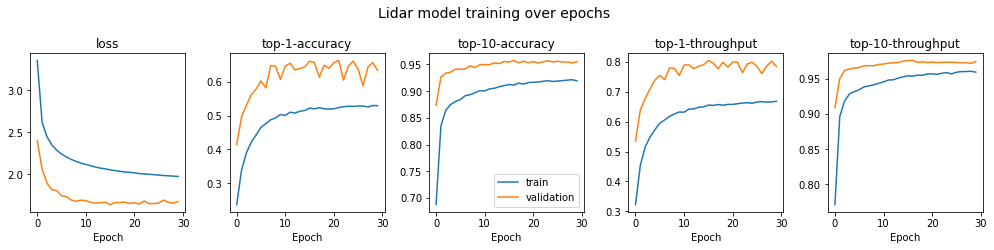

In [14]:
model_name = 'centralised-imperial'
with open(f'eval/{model_name}.json') as file:
    epoch_data = json.load(file)['history']

fig, axs = plt.subplots(1, len(metrics), figsize=(14, 3.5))
fig.suptitle('Lidar model training over epochs', fontsize=14)
for ax, metric in zip(axs, metrics):
    ax.set_title(metric)
    ax.plot(np.arange(30), epoch_data[metric], label='train')
    ax.plot(np.arange(30), epoch_data[f'val_{metric}'], label='validation')
    ax.set_xlabel('Epoch')
axs[2].legend()
plt.tight_layout()
plt.savefig('figs/centralised-imperial-metrics.png')

### Training and Validation loss, accuracy and throughput over epochs with different models

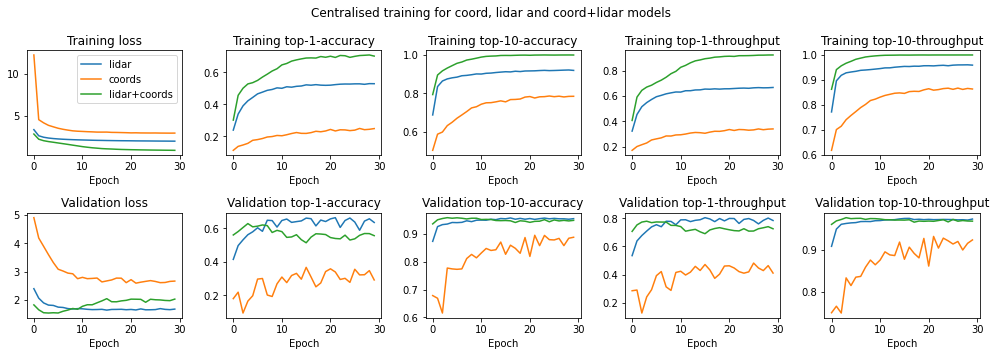

In [15]:
model_names = ['centralised-imperial', 'centralised-beamsoup-coord', 'centralised-southampton']
model_results = {}
for model_name in model_names:
    with open(f'eval/{model_name}.json') as file:
        model_results[model_name] = json.load(file)['history']
    
names = ['lidar', 'coords', 'lidar+coords']
fig, axs = plt.subplots(2, 5, figsize=(14, 5))
fig.suptitle('Centralised training for coord, lidar and coord+lidar models')
for pos, metric in enumerate(metrics):
    axs[0, pos].set_title(f'Training {metric}')
    axs[1, pos].set_title(f'Validation {metric}')
    for name, model_name in zip(names, model_names):
        axs[0, pos].plot(np.arange(30), model_results[model_name][metric], label=name)
        axs[1, pos].plot(np.arange(30), model_results[model_name][f'val_{metric}'], label=name)
[ax.set_xlabel('Epoch') for ax in axs.flatten()]
axs[0, 0].legend()
plt.tight_layout()
plt.savefig('figs/centralised-training-val-metrics.png')

### V2 Training and Validation loss, accuracy and throughput over epochs

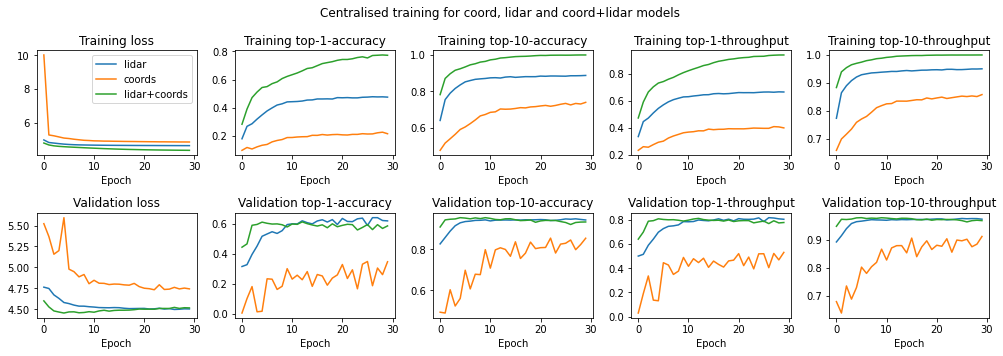

In [16]:
model_names = ['centralised-imperial-v2', 'centralised-beamsoup-coord-v2', 'centralised-southampton-v2']
model_results = {}
for model_name in model_names:
    with open(f'eval/{model_name}.json') as file:
        model_results[model_name] = json.load(file)['history']
    
names = ['lidar', 'coords', 'lidar+coords']
fig, axs = plt.subplots(2, 5, figsize=(14, 5))
fig.suptitle('Centralised training for coord, lidar and coord+lidar models')
for pos, metric in enumerate(metrics):
    axs[0, pos].set_title(f'Training {metric}')
    axs[1, pos].set_title(f'Validation {metric}')
    for name, model_name in zip(names, model_names):
        axs[0, pos].plot(np.arange(30), model_results[model_name][metric], label=name)
        axs[1, pos].plot(np.arange(30), model_results[model_name][f'val_{metric}'], label=name)
[ax.set_xlabel('Epoch') for ax in axs.flatten()]
axs[0, 0].legend()
plt.tight_layout()
plt.savefig('figs/centralised-v2-training-val-metrics.png')

### Federated learning of global models with different numbers of vehicles

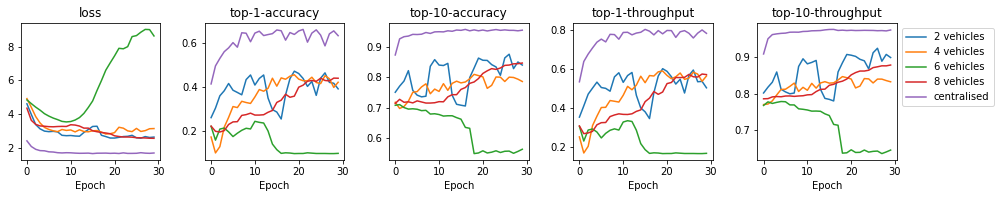

In [17]:
model_results = {}
for vehicles in (2, 4, 6, 8):
    with open(f'eval/federated-{vehicles}-imperial.json') as file:
        model_results[f'{vehicles} vehicles'] = json.load(file)['history']['global']
with open(f'eval/centralised-imperial.json') as file:
    model_results['centralised'] = json.load(file)['history']

fig, axs = plt.subplots(1, len(metrics), figsize=(14, 3))
fig.suptitle('')
for pos, metric in enumerate(metrics):
    axs[pos].set_title(metric)
    for vehicles in ['2 vehicles', '4 vehicles', '6 vehicles', '8 vehicles']:
        axs[pos].plot(np.arange(30), model_results[vehicles][metric], label=vehicles)
    axs[pos].plot(np.arange(30), model_results['centralised'][f'val_{metric}'], label='centralised')

[ax.set_xlabel('Epoch') for ax in axs.flatten()]
axs[-1].legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('figs/federated-global-training-val-metrics.png')

### Federated learning of global models with different models

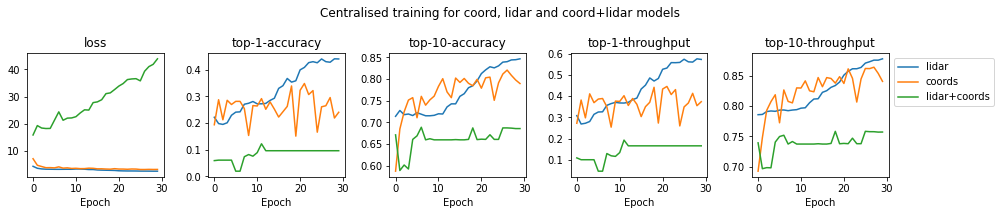

In [18]:
model_names = ['federated-8-imperial', 'federated-8-beamsoup-coord', 'federated-8-southampton']
model_results = {}
for model_name in model_names:
    with open(f'eval/{model_name}.json') as file:
        model_results[model_name] = json.load(file)['history']['global']
    
names = ['lidar', 'coords', 'lidar+coords']
fig, axs = plt.subplots(1, len(metrics), figsize=(14, 3))
fig.suptitle('Centralised training for coord, lidar and coord+lidar models')

for pos, metric in enumerate(metrics):
    axs[pos].set_title(metric)
    for name, model_name in zip(names, model_names):
        axs[pos].plot(np.arange(30), model_results[model_name][metric], label=name)
        
[ax.set_xlabel('Epoch') for ax in axs.flatten()]
axs[-1].legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('figs/federated-models-training-val-metrics.png')

### Federated learning vehicle training and validation loss, accuracy and throughput over epochs

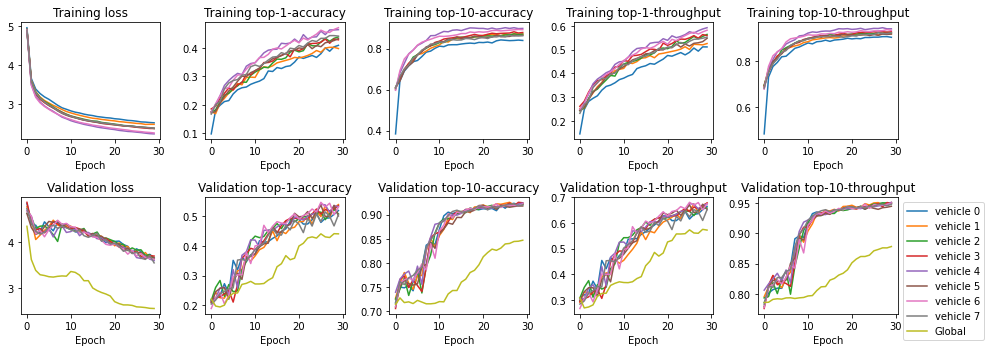

In [20]:
with open('eval/federated-8-imperial.json') as file:
    model_results = json.load(file)['history']

fig, axs = plt.subplots(2, 5, figsize=(14, 5))
for pos, metric in enumerate(metrics):
    axs[0, pos].set_title(f'Training {metric}')
    axs[1, pos].set_title(f'Validation {metric}')
    for model in [f'vehicle {i}' for i in range(8)]:
        axs[0, pos].plot(np.arange(30), model_results[model][metric], label=model)
        axs[1, pos].plot(np.arange(30), model_results[model][f'val_{metric}'], label=model)
    axs[1, pos].plot(np.arange(30), model_results['global'][metric], label='Global')
    
[ax.set_xlabel('Epoch') for ax in axs.flatten()]
axs[1, -1].legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('figs/federated-vehicles-training-val-metrics.png')

## Pruning

In [21]:
pruning_models = {'lidar': 'imperial',
                  'coords': 'beamsoup-coord',
                  'lidar+coords': 'southampton'}

pruning_sparsity = np.arange(0, 1, 0.05)
models_results = {}
for model_name, model_loc in pruning_models.items():
    print(model_name)
    _, dataset_fn = models[model_loc]
    model = tf.keras.models.load_model(f'models/centralised-{model_loc}/model',
                                       custom_objects={'TopKThroughputRatio': TopKThroughputRatio})
    _, validation_input = dataset_fn()
    _, validation_output = output_dataset()

    metrics = [
        tf.keras.metrics.TopKCategoricalAccuracy(k=1, name='top-1-accuracy'),
        tf.keras.metrics.TopKCategoricalAccuracy(k=10, name='top-10-accuracy'),
        TopKThroughputRatio(k=1, name='top-1-throughput'),
        TopKThroughputRatio(k=10, name='top-10-throughput')
    ]
    model_results = {name: [] for name in [m.name for m in metrics] + ['loss', 'model-size', 'weights-size', 'time']}
    for sparsity in tqdm(pruning_sparsity):
        start_time = perf_counter()
        pruned_model = prune_model(model, sparsity)
        
        model_results['time'].append(perf_counter() - start_time)
        model_results['model-size'].append(get_gzipped_model_size(pruned_model))
        model_results['weights-size'].append(get_gzipped_model_weights_size(pruned_model))
        
        pruned_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), metrics=metrics)
        pruned_model_results = pruned_model.evaluate(validation_input, validation_output, return_dict=True, verbose=0)
        for metric_name, value in pruned_model_results.items():
            model_results[metric_name].append(value)
    models_results[model_name] = model_results

lidar


100%|██████████| 20/20 [00:34<00:00,  1.73s/it]


coords


100%|██████████| 20/20 [00:07<00:00,  2.75it/s]


lidar+coords


100%|██████████| 20/20 [01:16<00:00,  3.81s/it]


['lidar', 'coords', 'lidar+coords']


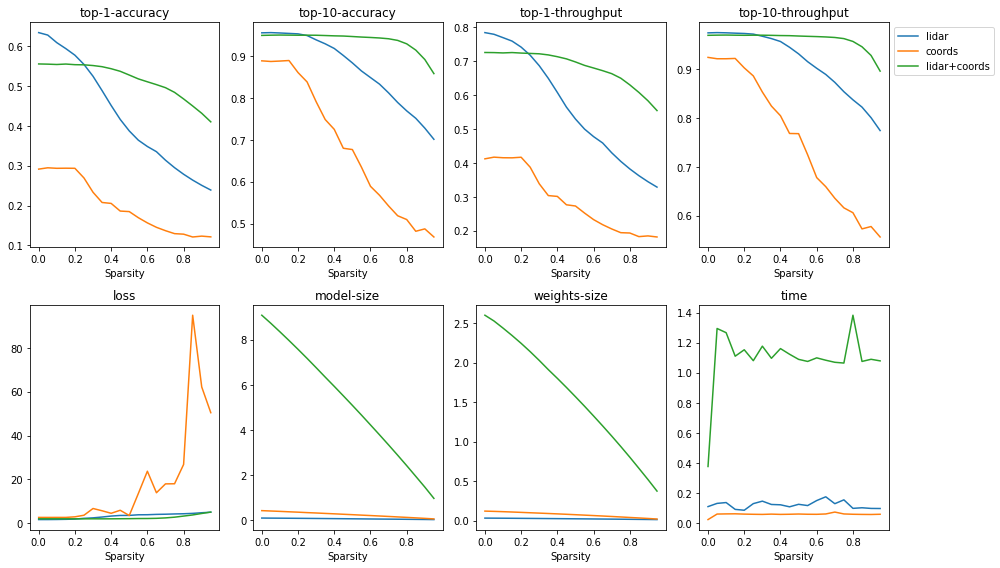

In [22]:
model_names = list(models_results.keys())
print(model_names)
metrics = models_results[model_names[0]].keys()

fig, axs = plt.subplots(2, len(metrics) // 2, figsize=(14, 8))
for ax, metric in zip(axs.flatten(), metrics):
    ax.set_title(metric)
    ax.set_xlabel('Sparsity')
    for model_name in model_names:
        ax.plot(np.arange(0, 1, 0.05), models_results[model_name][metric], label=model_name)
axs[0, -1].legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('figs/pruning.png')